In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [164]:
# read the data
data = pd.read_csv("../results/inf_outf.csv", index_col=0)
# convert index to datetime
data.index = pd.to_datetime(data.index)

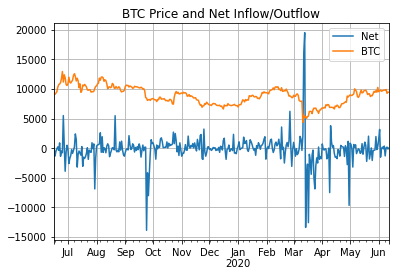

In [168]:
# let's look at inflow/outflow and price
data.drop(columns=["volume", "inflow", "outflow"]).plot()
plt.title("BTC Price and Net Inflow/Outflow")
plt.legend(["Net", "BTC"])
plt.grid(True)

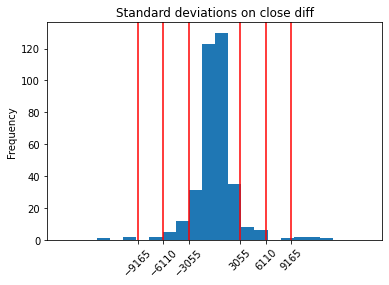

In [187]:
# calculate the daily change
diff = data.net.diff()
# the standard deviation in daily change
s = diff.std()

# let's observe the variances in change in net in/out
diff.plot.hist(bins=30)
for i in range(3):
    plt.axvline(s*(1+i), color='r')
    plt.axvline(s*(-(i+1)), color='r')
    
plt.title("Standard deviations on close diff")
plt.xticks([s*(-(1+i)) for i in reversed(range(3))] + [s*(1+i) for i in range(3)], rotation=45)
plt.xlim(-20000, 20000)
plt.show()

In [146]:
sigma = 2.5*s      # what we consider anomolous inflow/outflow

# calculating days of large than average net flow
data["net_diff"] = data.net.diff().fillna(0)
data["anom"] = np.where(abs(data.net_diff) > sigma, 1, 0)

print("{:.3f}".format(100*(1-sum(data.anom)/len(data))) + "% non-anomolous days")

97.245% non-anomolous days


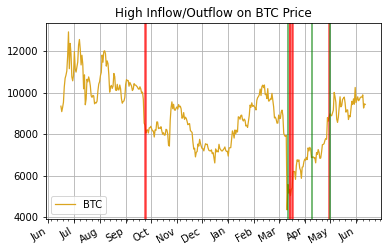

In [161]:
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%b')
weeks = mdates.WeekdayLocator()

fig, ax = plt.subplots()

ax.plot(data.close, color="goldenrod", lw=1.25)

# add the high inflow/outflow days
for i in data.index[data.anom==1]:
    if data.loc[i].net > 0:
        ax.axvline(i, color='g', alpha=0.7)
    else:
        ax.axvline(i, color='r', alpha=0.7)
    
# set the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(weeks)

# add grid
ax.grid(True)
ax.set_title("High Inflow/Outflow on BTC Price")
# format ticks
fig.autofmt_xdate()
ax.legend(["BTC"])
plt.show()